In [0]:
import numpy as np
import torch
import torch.nn as nn
import copy
import itertools
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torchvision

torch.manual_seed(1337)
np.random.seed(1337)

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    torch.cuda.manual_seed(1337)
else:
    DEVICE = None

In [0]:
X_DIM = 28 * 28
Y_DIM = 10
Z_DIM = 50
HIDDEN_DIM1 = 600
HIDDEN_DIM2 = 500
INIT_VAR = 0.001
C = 0.5


def ohe_convert(y):
    res = torch.zeros(len(y), Y_DIM)
    res[torch.arange(len(y)), y.squeeze()] = 1
    return res.to(y.device)


class M1(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.encoder_z = torch.nn.Sequential(
            nn.Linear(X_DIM, HIDDEN_DIM1),
            nn.Softplus(),
            nn.Linear(HIDDEN_DIM1, HIDDEN_DIM1),
            nn.Softplus(),
            nn.Linear(HIDDEN_DIM1, Z_DIM * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(Z_DIM, HIDDEN_DIM1),
            nn.Softplus(),
            nn.Linear(HIDDEN_DIM1, HIDDEN_DIM1),
            nn.Softplus(),
            nn.Linear(HIDDEN_DIM1, X_DIM),
            nn.Softmax()
        )

        for p in self.parameters():
            if p.ndim == 1:
                p.data.fill_(0)
            else:
                p.data.normal_(0, INIT_VAR)
        
        self.p_z = torch.distributions.Normal(
            torch.zeros(1, device=device), 
            torch.ones(1, device=device)
        )


    def encode_z(self, x):
        means_z, logsigma_z = torch.chunk(self.encoder_z(x), 2, dim=-1)
        sigma_z = torch.exp(logsigma_z)
        return torch.distributions.Normal(means_z, sigma_z), means_z, sigma_z


    def decode(self, z):
        return torch.distributions.Bernoulli(probs=self.decoder(z))


In [0]:
LR = 0.0003
BETA1 = 0.9
BETA2 = 0.999
ALPHA = 0.1

def train_M1(model: M1, dl_labeled, dl_unlabeled, dl_test, n_epochs, device):
    def loss_func(x, z, mu_z, sigma_z, y):
        k = mu_z.shape[1]
        KL = 0.5 * (torch.norm(mu_z, dim=1)**2 + torch.sum(sigma_z - torch.log(sigma_z)) - k)
        RE = torch.sum((x - y) ** 2, dim=1) * C
        L = RE - KL
        return L
    opt = torch.optim.Adam(model.parameters(), lr=LR, betas=(BETA1, BETA2))
    train_loss_log, val_loss_log = [], []
    for epoch in tqdm(range(n_epochs)):
        batches = itertools.chain(iter(dl_labeled), iter(dl_unlabeled))
        model.train()
        for x, _ in batches:
            x = x.view(x.shape[0], -1).to(device)
            q_z_x, mu_z, sigma_z = model.encode_z(x.squeeze())
            z = model.p_z.sample() * sigma_z + mu_z
            p_x_z = model.decode(z)
            x_ = p_x_z.sample()
            opt.zero_grad()
            loss = -loss_func(x, z, mu_z, sigma_z, x_)
            loss = loss.mean(0)
            loss.backward()
            opt.step()
        train_loss_log.append(loss.data.item())
        model.eval()
        for x, _ in dl_test:
            x = x.view(x.shape[0], -1).to(device)
            q_z_x, mu_z, sigma_z = model.encode_z(x.squeeze())
            z = q_z_x.sample()
            p_x_z = model.decode(z)
            x_ = p_x_z.sample()
            loss = -loss_func(x, z, mu_z, sigma_z, x_)
            loss = loss.mean(0)
        val_loss_log.append(loss.data.item())
        plot_history_M1(train_loss_log, val_loss_log)


@torch.no_grad()
def evaluate(model, dl, device):
    model.eval()
    accurate_preds = 0
    all_count = 0
    for x, y in dl:
        all_count += x.shape[0]
        x = x.to(device).view(x.shape[0], -1)
        y = y.to(device)
        preds = model(x)
        accurate_preds += (preds == y).sum().item()

    return accurate_preds / all_count

def plot_history_M1(train_history, val_history):
    clear_output()
    plt.figure()
    plt.title('Loss')
    plt.plot(np.arange(len(train_history)), train_history, label='train', zorder=1)
    plt.plot(np.arange(len(val_history)), val_history, label='vals', zorder=1)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


In [0]:
def load_data(n_labeled, batch_size=64):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    train_labeled = torchvision.datasets.MNIST(PATH, download=True, train=True, transform=transforms)
    train_unlabeled = copy.deepcopy(train_labeled)

    n_classes = np.unique(train_labeled.train_labels).size
    n_labeled_class = n_labeled // n_classes

    x_labeled, y_labeled, x_unlabeled, y_unlabeled = map(lambda x: [], range(4))
    for i in range(n_classes):
        mask = train_labeled.train_labels == i
        x_masked = train_labeled.data[mask]
        y_masked = train_labeled.train_labels[mask]
        np.random.shuffle(x_masked)

        x_labeled.append(x_masked[:n_labeled_class])
        x_unlabeled.append(x_masked[n_labeled_class:])
        y_labeled.append(y_masked[:n_labeled_class])
        y_unlabeled.append(y_masked[n_labeled_class:])

    
    train_unlabeled.data = torch.cat(x_unlabeled).squeeze()
    train_unlabeled.labels = torch.cat(y_unlabeled)
    train_labeled.data = torch.cat(x_labeled).squeeze()
    train_labeled.labels = torch.cat(y_labeled)

    dl_train_labeled = torch.utils.data.DataLoader(train_labeled, batch_size=batch_size, shuffle=True)
    dl_train_unlabeled = torch.utils.data.DataLoader(train_unlabeled, batch_size=batch_size, shuffle=True)

    test = torchvision.datasets.MNIST(PATH, download=True, train=False, transform=transforms)
    dl_test = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

    return dl_train_labeled, dl_train_unlabeled, dl_test


In [0]:
dl_labeled, dl_unlabeled, dl_test = load_data(3000)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [0]:
model = M1(DEVICE).to(DEVICE)

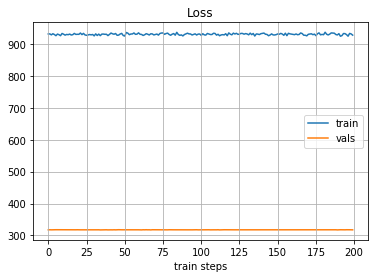

100%|██████████| 200/200 [24:22<00:00,  7.39s/it]


In [0]:
train_M1(model, dl_labeled, dl_unlabeled, dl_test, 200, DEVICE)

In [0]:
model.eval()
def convert(dl):
  Xs, Ys = [], []
  for x, y in dl_labeled:
    x = x.view(x.shape[0], -1).to(DEVICE)
    q_z_x, mu_z, sigma_z = model.encode_z(x.squeeze())
    z = q_z_x.sample()
    Xs.append(z.cpu().numpy())
    Ys.append(y.cpu().numpy())

  return np.vstack(Xs), np.hstack(Ys)

In [0]:
X_train, y_train = convert(dl_labeled)
X_test, y_test = convert(dl_test)

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C=3.)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=3.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
accuracy_score(clf.predict(X_test), y_test)

0.099